## Aplicando o bert ao dados dos reviews

In [1]:
!pip install -q tf-models-official==2.3.0

     |████████████████████████████████| 840 kB 5.3 MB/s 
     |████████████████████████████████| 47.8 MB 1.3 MB/s 
     |████████████████████████████████| 352 kB 59.5 MB/s 
     |████████████████████████████████| 237 kB 51.4 MB/s 
     |████████████████████████████████| 1.2 MB 54.2 MB/s 
     |████████████████████████████████| 99 kB 8.7 MB/s 
     |████████████████████████████████| 1.1 MB 10.4 MB/s 
     |████████████████████████████████| 462 kB 46.3 MB/s 


### Imports

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

This directory contains the configuration, vocabulary, and a pre-trained checkpoint:

In [3]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [4]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

##Dados

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

df_reviews =  pd.read_csv('df_tratado.csv')
df_reviews['data'] = pd.to_datetime(df_reviews['data'], format="%Y-%m-%d")
df_reviews.head()

,controle_review_longo,data,nota,Notas
0,Que sensacional! O modelo da minha tv é uma da...,2021-05-10,5,Positivo
1,Devo dizer que estou bem decepcionado.\nCompre...,2021-07-13,2,Negativo
2,Eu comprei esse modelo justamente pelos botões...,2021-05-15,3,Positivo
3,"Pow, Amazon, que isso? vcs eram tão competente...",2021-09-27,1,Negativo
4,Pontos positivos: o processo de instalação é b...,2021-05-17,5,Positivo


In [12]:
# Convertendo as avaliações
def converteCategoria(df, coluna):
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(df[coluna])
    df[coluna] = le.transform(df[coluna])
    return le

labelEncoderNotas = converteCategoria(df_reviews, 'Notas')
df_reviews.head()

,controle_review_longo,data,nota,Notas
0,Que sensacional! O modelo da minha tv é uma da...,2021-05-10,5,1
1,Devo dizer que estou bem decepcionado.\nCompre...,2021-07-13,2,0
2,Eu comprei esse modelo justamente pelos botões...,2021-05-15,3,1
3,"Pow, Amazon, que isso? vcs eram tão competente...",2021-09-27,1,0
4,Pontos positivos: o processo de instalação é b...,2021-05-17,5,1


In [15]:
# container for sentences
reviews = np.array([review for review in df_reviews['controle_review_longo']])

# container for labels
labels = np.array([label for label in  df_reviews['Notas']])

In [16]:
# Usando train-test split
from sklearn.model_selection import train_test_split

train, validation, train_labels, validation_labels = train_test_split(reviews, labels, 
                                                      test_size=0.40, stratify=labels)

In [19]:
validation, test, validation_labels, test_labels = train_test_split(validation, validation_labels, 
                                                     test_size=0.50, stratify=validation_labels)

In [20]:
def convert_to_dict(reviews,labels):
  reviews = reviews
  labels = labels
  
  return {'reviews': reviews, 'labels':labels}

In [21]:
train = convert_to_dict(train,train_labels)
validation = convert_to_dict(validation,validation_labels)
test = convert_to_dict(test,test_labels)

### The BERT tokenizer

To fine tune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during training.

The BERT tokenizer used in this tutorial is written in pure Python (It's not built out of TensorFlow ops). So you can't just plug it into your model as a `keras.layer` like you can with `preprocessing.TextVectorization`.

The following code rebuilds the tokenizer that was used by the base model:

In [22]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


#### Encode the sentences

The model expects its two inputs sentences to be concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token:

In [23]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Start by encoding all the sentences while appending a `[SEP]` token, and packing them into ragged-tensors:

In [24]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

reviews = tf.ragged.constant([encode_sentence(s[:500]) for s in train['reviews']])

In [25]:
print("Reviews shape:", reviews.shape.as_list())
#print("Sentence2 shape:", sentence2.shape.as_list())

Reviews shape: [906, None]


Now prepend a `[CLS]` token, and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. `RaggedTensor.to_tensor()` zero pads to the longest sequence.

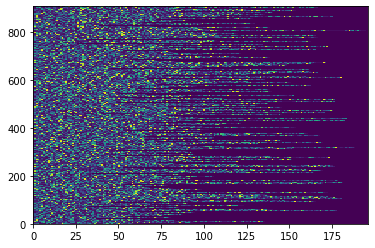

In [26]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * reviews.shape[0]
input_word_ids = tf.concat([cls, reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

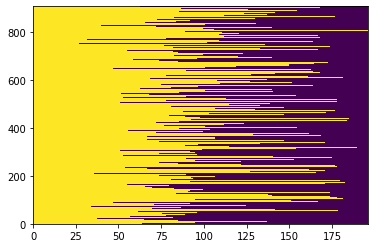

In [27]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

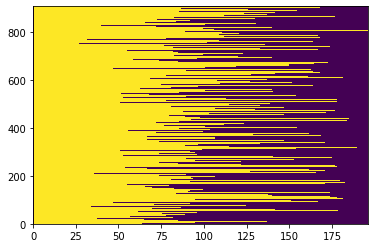

In [28]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.ones_like(reviews)
input_type_ids = tf.concat([type_cls, type_s1], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

#### Put it all together

Collect the above text parsing code into a single function, and apply it to each split of the `glue/mrpc` dataset.

In [29]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(imdb, tokenizer):
  num_examples = len(imdb['reviews'])
  
  review = tf.ragged.constant([
      encode_sentence(s[:500], tokenizer)
      for s in imdb["reviews"]])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * review.shape[0]
  input_word_ids = tf.concat([cls, review], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.ones_like(review)
  
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [30]:
len(train["reviews"])

906

In [32]:
train_enc = bert_encode(train, tokenizer)
train_labels = np.array(train['labels'])

validation_enc = bert_encode(validation, tokenizer)
validation_labels = np.array(validation['labels'])

test_enc = bert_encode(test, tokenizer)
test_labels  = np.array(test['labels'])

Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [33]:
for key, value in train_enc.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'imdb_train_labels shape: {train_labels.shape}')

input_word_ids  shape: (906, 196)
input_mask      shape: (906, 196)
input_type_ids  shape: (906, 196)
imdb_train_labels shape: (906,)


### Build the model


The first step is to download the configuration  for the pre-trained model.


In [34]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The `config` defines the core BERT Model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

This function returns both the encoder and the classifier.

In [35]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

The classifier has three inputs and one output:

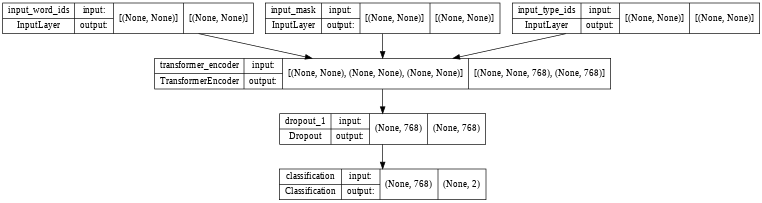

In [36]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [37]:
train_enc

{'input_mask': <tf.Tensor: shape=(906, 196), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(906, 196), dtype=int32, numpy=
 array([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(906, 196), dtype=int32, numpy=
 array([[  101,  2139,  2146, ...,     0,     0,     0],
        [  101,  8529,  4013, ...,     0,     0,     0],
        [  101, 25957, 26036, ...,     0,     0,     0],
        ...,
        [  101,  1037, 16021, ...,     0,     0,     0],
        [  101,  2572,  7416, ...,     0,     0,     0],
        [  101,  3653,  3597, ...,     0,    

In [38]:
for key, val in train.items():
  print(key, val)
  break

reviews ['De longe o melhor stick para você ter uma smart TV funcional em casa. Tem integração com Alexa, suporta comandos de voz para a TV e para os apps do FireTV. Não tem todos os apps de todos os serviços de assinatura, infelizmente (como HBO Max e GloboPlay e isso não é culpa da Amazon e sim dos serviços), mas tem da maioria e com uma "pequena gambiarra" vc tem o HBO Max e outros. Recomendadíssimo!'
 'Um produto interessante ! Caso não tenha uma smart TV, esse produto é perfeito, principalmente devido a função da Alexa para buscar conteúdo por voz (para idosos e crianças que tenham dificuldade de manipular e digitar com o teclado virtual).\nContudo, gostaria de salientar que se você quiser integrar com algum ECHO DOT 3ª Geração, algumas vezes ocorrem falhas na hora de reproduzir ou então, se você for realizar os comandos por voz, através da ECHO DOT 3ª geração, alguns comandos podem não ser realizados. Nesse caso, o controle do FIRE TV STICK se torna a única forma de controlar.'
 

In [40]:
batch = {key: val[:10,:500] for key, val in train_enc.items()}

In [41]:
batch

{'input_mask': <tf.Tensor: shape=(10, 196), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(10, 196), dtype=int32, numpy=
 array([[0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(10, 196), dtype=int32, numpy=
 array([[  101,  2139,  2146, ...,     0,     0,     0],
        [  101,  8529,  4013, ...,     0,     0,     0],
        [  101, 25957, 26036, ...,     0,     0,     0],
        ...,
        [  101,  1051,  2543, ...,     0,     0,     0],
        [  101,  2175, 13473, ...,     0,     0,     0],
        [  101,  4013,  8566, ...,     0,     0,

In [42]:
bert_classifier(
    batch, training=True
).numpy()

array([[-0.0234043 , -0.29809663],
       [ 0.03783626, -0.41359195],
       [-0.19901635, -0.29799592],
       [-0.23756647, -0.01628798],
       [-0.01195789, -0.265296  ],
       [ 0.02476241, -0.17629783],
       [-0.10924938, -0.4047715 ],
       [ 0.01154892, -0.4303041 ],
       [ 0.06925911, -0.3172935 ],
       [-0.22767088, -0.33449954]], dtype=float32)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

Inspecting the encoder, we see its stack of `Transformer` layers connected to those same three inputs:

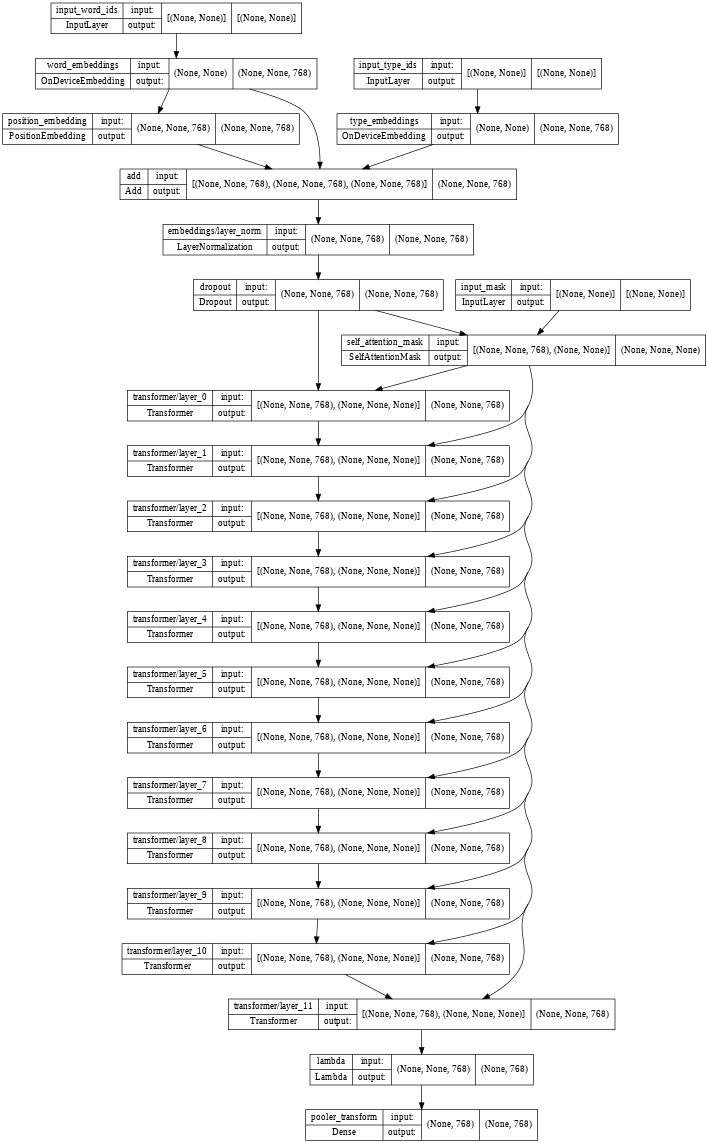

In [43]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [44]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). See the [Hub appendix](#hub_bert) for details. 

### Set up the optimizer

BERT adopts the Adam optimizer with weight decay (aka "[AdamW](https://arxiv.org/abs/1711.05101)").
It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [45]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

This returns an `AdamWeightDecay`  optimizer with the learning rate schedule set:

In [46]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

### Train the model

The metric is accuracy and we use sparse categorical cross-entropy as loss.

In [47]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      train_enc, train_labels,
      validation_data=(validation_enc, validation_labels),
      batch_size=8,
      epochs=epochs)

Epoch 1/3
114/114 [==============================] - 2285s 20s/step - loss: 0.3284 - accuracy: 0.9084 - val_loss: 0.3030 - val_accuracy: 0.9139
Epoch 2/3
114/114 [==============================] - 2250s 20s/step - loss: 0.3024 - accuracy: 0.9128 - val_loss: 0.3030 - val_accuracy: 0.9139
Epoch 3/3
114/114 [==============================] - 2267s 20s/step - loss: 0.3043 - accuracy: 0.9128 - val_loss: 0.3030 - val_accuracy: 0.9139


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [48]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

TypeError: ignored

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [49]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

NameError: ignored

In [ ]:
np.array(info.features['label'].names)[result]

### Save the model

Often the goal of training a model is to _use_ it for something, so export the model and then restore it to be sure that it works.

In [ ]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

In [ ]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())